In [1]:
import torch
import time
from diffusers import DiffusionPipeline
from diffusers import EulerAncestralDiscreteScheduler

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device()), torch.version.cuda, torch.backends.cudnn.version()

('Tesla V100-SXM2-16GB', '11.8', 8700)

In [3]:
torch.nn.functional.scaled_dot_product_attention

<function torch._C._nn.scaled_dot_product_attention>

In [4]:
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",    
    torch_dtype=torch.float16,
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
# pipe.enable_attention_slicing()

In [5]:
# pipe.unet = torch.compile(pipe.unet)
pipe.enable_xformers_memory_efficient_attention()

In [11]:
batch_size_list = [2 ** x for x in range(0, 5)]
steps = 50
cfg_scale = 15
prompt = "postapocalyptic steampunk city, exploration, cinematic, realistic, hyper detailed, photorealistic maximum detail, volumetric light, (((focus))), wide-angle, (((brightly lit))), (((vegetation))), lightning, vines, destruction, devastation, wartorn, ruins"
negative_prompt = "(((blurry))), ((foggy)), (((dark))), ((monochrome)), sun, (((depth of field)))"

In [12]:
# prewarm
_ = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    num_images_per_prompt=1,
    guidance_scale=cfg_scale,
    height=512,
    width=512,
    ).images

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
result = []
for batch_size in batch_size_list:
    t0 = time.time()
    images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        num_images_per_prompt=batch_size,
        guidance_scale=cfg_scale,
        height=512,
        width=512,
        ).images
    t1 = time.time()

    its = steps * batch_size / (t1 - t0)
    print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))
    result.append(round(its, 2))

  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 1, it/s: 17.4, time: 2.87


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 2, it/s: 21.72, time: 4.6


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 4, it/s: 24.59, time: 8.13


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 8, it/s: 25.99, time: 15.39


  0%|          | 0/50 [00:00<?, ?it/s]

batch_size 16, it/s: 26.9, time: 29.74


In [9]:
result

[17.58, 21.25, 24.52, 25.96, 26.77]

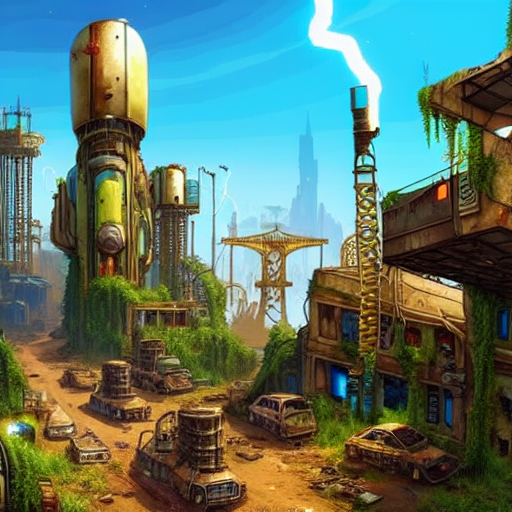

In [10]:
images[0]